## Task 10: Plotting Bias-Variance Tradeoff and Correlation

In [85]:
import argparse
import yaml
import numpy as np
import pickle as pkl
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from itertools import product
from datetime import datetime
import json
import hashlib
import os
import matplotlib.pyplot as plt

from algorithms import BMP
from data_generation import GaussianDataGenerator

In [4]:
p = 300
n = 600
m = 20
noise_level = 0.2

Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, random_seed=1)
_ = Data_Geneartor.shuffle()

In [5]:
(
    test_true_signal,
    test_dictionary,
    true_indices,
    true_coefficients,
    test_perturbed_signal,
) = Data_Geneartor.get_current_shuffle()
print(test_perturbed_signal[:5])
print(true_coefficients[:5])

[[ 0.05826719]
 [-0.329659  ]
 [-0.62405756]
 [ 0.19549826]
 [ 0.29230804]]
[[ 0.64427199]
 [-0.96876819]
 [ 0.21446787]
 [ 0.18492569]
 [ 1.33144795]]


In [6]:
train_seed = 33
(
    train_true_signal,
    train_dictionary,
    true_indices,
    true_coefficients,
    train_perturbed_signal,
) = Data_Geneartor.keep_coef_reshuffle(seed = train_seed)

In [7]:
model_params = {
    'N_bag': 100,
    'K': 20,
    'signal_bag_percent': 0.3,
    'atom_bag_percent': 0.3,
    'agg_func': 'avg',
    'replace_flag': False
}

bmp_model = BMP(**model_params)

In [8]:
bmp_model.fit(train_dictionary, train_perturbed_signal)
y_pred = bmp_model.predict(test_dictionary)
bmp_model.score(test_dictionary, test_perturbed_signal)

0.041208068908968165

Now we are ready to calculate bias variance and correlation of y_pred

In [27]:
def cal_bias_variance_corr(n, p, m, data_seed, noise_level, model_params, test_num):
    Data_Geneartor = GaussianDataGenerator(p, n, m, noise_level, data_seed)
    test_true_signal, test_dictionary, true_indices, true_coefficients, test_perturbed_signal = Data_Geneartor.shuffle()
    bmp_model = BMP(**model_params)
    y_pred_lst = []
    mse_lst = []
    corr_lst = []
    for test_i in range(test_num):
        _, train_dictionary, _, _, train_perturbed_signal = Data_Geneartor.keep_coef_reshuffle(seed = test_i + 100)
        bmp_model.fit(train_dictionary, train_perturbed_signal)
        y_pred = bmp_model.predict(test_dictionary)
        y_pred_lst.append(y_pred)
        mse_lst.append(bmp_model.score(test_dictionary, test_perturbed_signal))
    y_pred_mat = np.concatenate(y_pred_lst, axis = 1)
    y_pred_mean = np.mean(y_pred_mat, axis = 1)
    y_pred_var = np.var(y_pred_mat, axis = 1)
    y_pred_bias = y_pred_mean - test_true_signal.ravel()
    
    # TODO: correlation need to be debugged
    y_pred_corr = np.corrcoef(y_pred_mat, rowvar = False)
    return y_pred_bias, y_pred_var, y_pred_corr, mse_lst

In [28]:
model_params = {
    'N_bag': 1,
    'K': 20,
    'signal_bag_percent': 0.3,
    'atom_bag_percent': 0.3,
    'agg_func': 'avg',
    'replace_flag': False
}

p = 300
n = 600
m = 20
noise_level = 0.2
data_seed = 1

y_pred_bias, y_pred_var, y_pred_corr, mse_lst = cal_bias_variance_corr(n, p, m, data_seed, noise_level, model_params, 50)

In [29]:
print(y_pred_bias.shape, y_pred_var.shape, y_pred_corr.shape)

(600,) (600,) (50, 50)


In [39]:
corr_lst = y_pred_corr[np.triu_indices(len(y_pred_corr), k=1)]
len(corr_lst)

1225

Text(0.5, 1.0, 'Mean bias square of testing set')

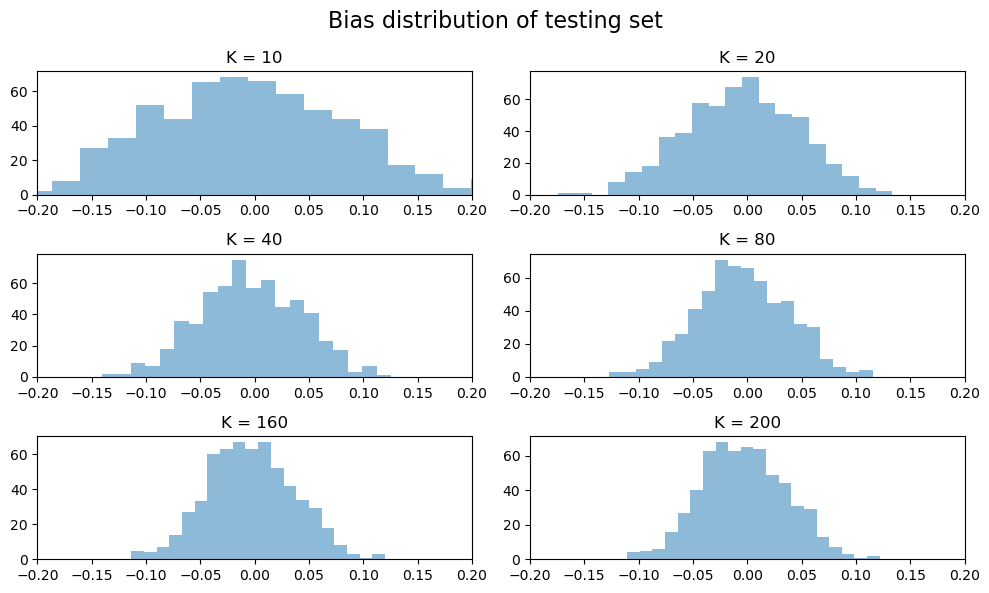

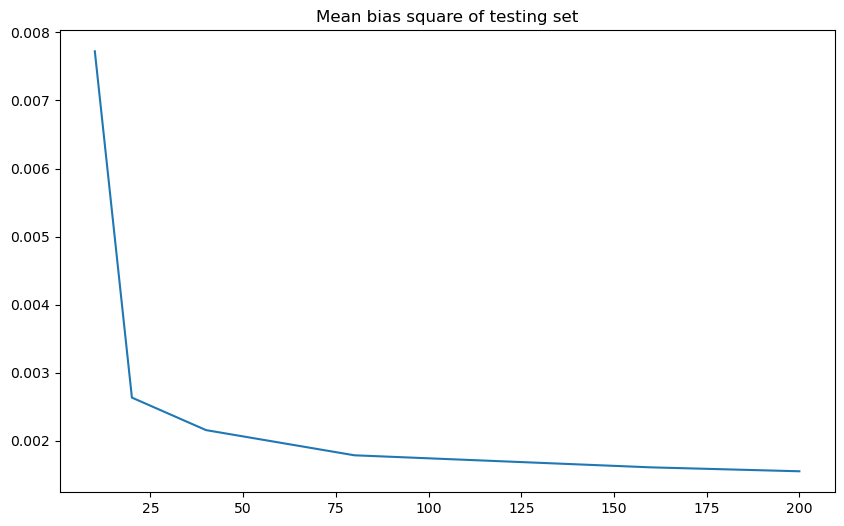

In [37]:
K_lst = [10, 20, 40, 80, 160, 200]
fig, ax = plt.subplots(3, 2, figsize=(10, 6))
y_pred_mean_bias_square = []
for i, K in enumerate(K_lst):
    row = i // 2
    col = i % 2
    model_params = {
        'N_bag': 1,
        'K': K,
        'signal_bag_percent': 0.3,
        'atom_bag_percent': 0.3,
        'agg_func': 'avg',
        'replace_flag': False
    }
    y_pred_bias, y_pred_var, corr, mse_lst = cal_bias_variance_corr(n, p, m, data_seed, noise_level, model_params, 100)
    y_pred_mean_bias_square.append(np.mean(y_pred_bias**2))
    ax[row, col].hist(y_pred_bias, bins=20, alpha=0.5, label='bias')
    ax[row, col].set_title('K = {}'.format(K))
    plt.tight_layout()
    plt.setp(ax, xlim=(-0.2, 0.2))
    fig.suptitle('Bias distribution of testing set', fontsize=16)

fig2, ax2 = plt.subplots(1, 1, figsize=(10, 6))
ax2.plot(K_lst, y_pred_mean_bias_square)
ax2.set_title('Mean bias square of testing set')

Text(0.5, 1.0, 'Mean variance of testing set')

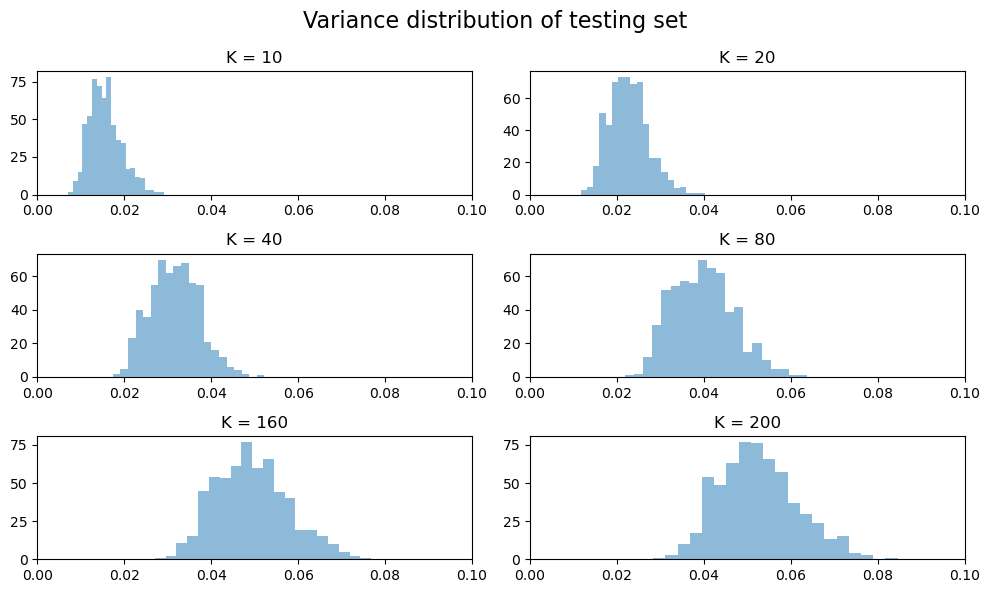

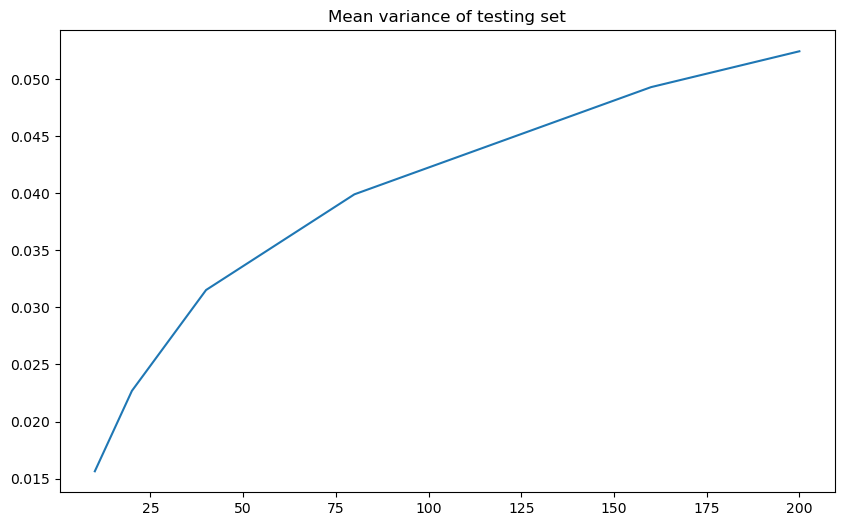

In [36]:
K_lst = [10, 20, 40, 80, 160, 200]
fig, ax = plt.subplots(3, 2, figsize=(10, 6))
y_pred_mean_var = []
for i, K in enumerate(K_lst):
    row = i // 2
    col = i % 2
    model_params = {
        'N_bag': 1,
        'K': K,
        'signal_bag_percent': 0.3,
        'atom_bag_percent': 0.3,
        'agg_func': 'avg',
        'replace_flag': False
    }
    y_pred_bias, y_pred_var, corr, mse_lst = cal_bias_variance_corr(n, p, m, data_seed, noise_level, model_params, 100)
    y_pred_mean_var.append(np.mean(y_pred_var))
    ax[row, col].hist(y_pred_var, bins=20, alpha=0.5, label='bias')
    ax[row, col].set_title('K = {}'.format(K))
    plt.tight_layout()
    plt.setp(ax, xlim=(0, 0.1))
    fig.suptitle('Variance distribution of testing set', fontsize=16)
    
fig2, ax2 = plt.subplots(1, 1, figsize=(10, 6))
ax2.plot(K_lst, y_pred_mean_var)
ax2.set_title('Mean variance of testing set')

Text(0.5, 1.0, 'Mean correlation coef of testing set')

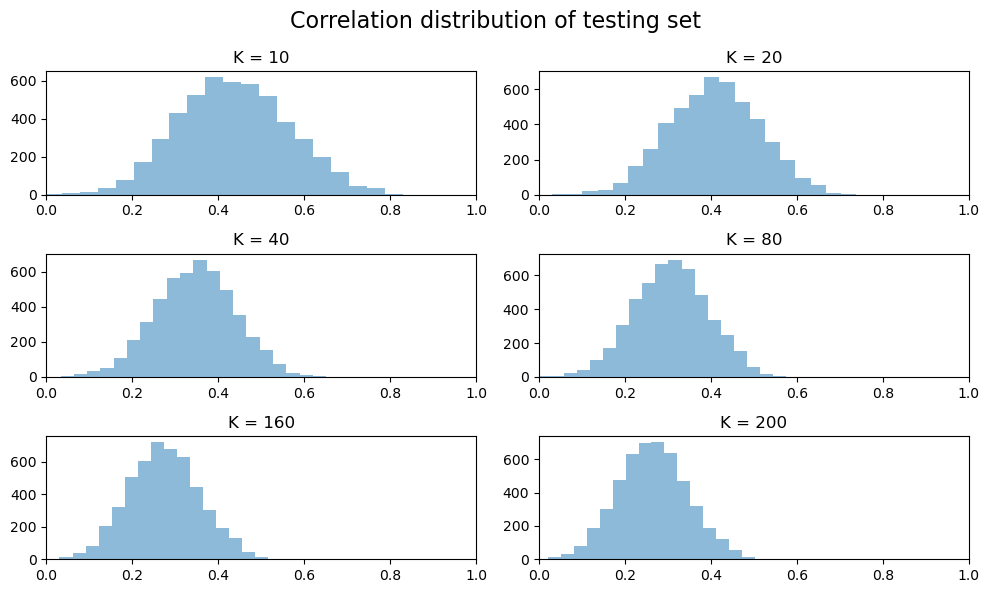

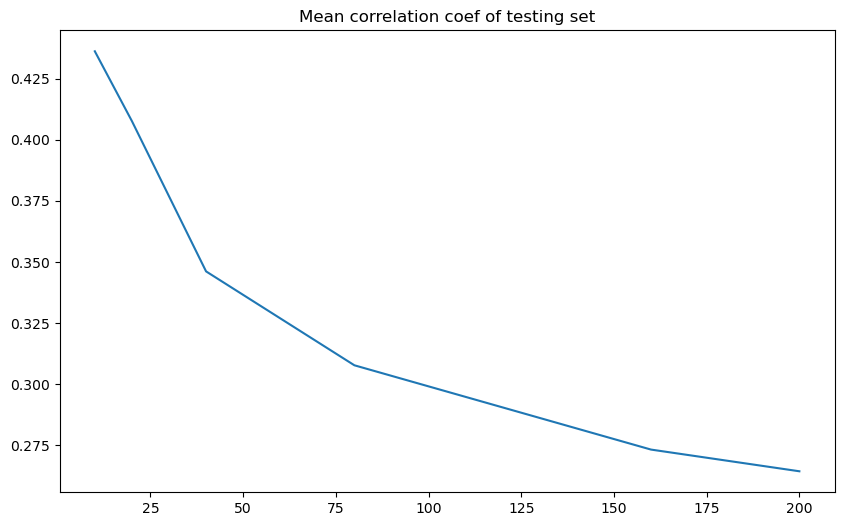

In [42]:
K_lst = [10, 20, 40, 80, 160, 200]
fig, ax = plt.subplots(3, 2, figsize=(10, 6))
y_pred_mean_corr = []
for i, K in enumerate(K_lst):
    row = i // 2
    col = i % 2
    model_params = {
        'N_bag': 1,
        'K': K,
        'signal_bag_percent': 0.3,
        'atom_bag_percent': 0.3,
        'agg_func': 'avg',
        'replace_flag': False
    }
    y_pred_bias, y_pred_var, corr, mse_lst = cal_bias_variance_corr(n, p, m, data_seed, noise_level, model_params, 100)
    # get the upper triangle elements of correlation matrix
    corr_lst = corr[np.triu_indices(len(corr), k=1)]
    y_pred_mean_corr.append(np.mean(corr_lst))
    ax[row, col].hist(corr_lst, bins=20, alpha=0.5, label='bias')
    ax[row, col].set_title('K = {}'.format(K))
    plt.tight_layout()
    plt.setp(ax, xlim=(0, 1))
    fig.suptitle('Correlation distribution of testing set', fontsize=16)
    
fig2, ax2 = plt.subplots(1, 1, figsize=(10, 6))
ax2.plot(K_lst, y_pred_mean_corr)
ax2.set_title('Mean correlation coef of testing set')

In [80]:
def plot_hists(noise_level, K_lst, row_p, col_p, test_num = 100):
    row_num = len(K_lst) // 2 if len(K_lst) % 2 == 0 else len(K_lst) // 2 + 1
    fig1, ax1 = plt.subplots(row_num, 2, figsize=(8, 6))
    fig2, ax2 = plt.subplots(row_num, 2, figsize=(8, 6))
    fig3, ax3 = plt.subplots(row_num, 2, figsize=(8, 6))
    fig4, ax4 = plt.subplots(row_num, 2, figsize=(8, 6))
    
    y_pred_mean_bias_square = []
    y_pred_mean_corr = []
    y_pred_mean_var = []
    mse_mean = []
    for i, K in enumerate(K_lst):
        row = i // 2
        col = i % 2
        model_params = {
            'N_bag': 1,
            'K': K,
            'signal_bag_percent': row_p,
            'atom_bag_percent': col_p,
            'agg_func': 'avg',
            'replace_flag': False
        }
        y_pred_bias, y_pred_var, corr, mse_lst = cal_bias_variance_corr(n, p, m, data_seed, noise_level, model_params, test_num)
        y_pred_mean_bias_square.append(np.mean(y_pred_bias**2))
        y_pred_mean_var.append(np.mean(y_pred_var))
        corr_lst = corr[np.triu_indices(len(corr), k=1)]
        y_pred_mean_corr.append(np.mean(corr_lst))
        mse_mean.append(np.mean(mse_lst))
        
        # Bias
        ax1[row, col].hist(y_pred_bias, bins=20, alpha=0.5, label='bias')
        ax1[row, col].set_title('K = {}'.format(K))
        fig1.tight_layout()
        plt.setp(ax1, xlim=(-0.2, 0.2))
        fig1.suptitle(f'Bias distribution of testing set\n(noise_level = {noise_level}, row_p = {row_p}, col_p = {col_p})', fontsize=12)
        
        # Variance
        ax2[row, col].hist(y_pred_var, bins=20, alpha=0.5, label='bias')
        ax2[row, col].set_title('K = {}'.format(K))
        fig2.tight_layout()
        plt.setp(ax2, xlim=(0, 0.1))
        fig2.suptitle(f'Variance distribution of testing set\n(noise_level = {noise_level},row_p = {row_p}, col_p = {col_p})', fontsize=12)
        
        # Correlation
        ax3[row, col].hist(corr_lst, bins=20, alpha=0.5, label='bias')
        ax3[row, col].set_title('K = {}'.format(K))
        fig3.tight_layout()
        plt.setp(ax3, xlim=(0, 1))
        fig3.suptitle(f'Correlation distribution of testing set\n(noise_level = {noise_level}, row_p = {row_p}, col_p = {col_p})', fontsize=12)
        
        fig4.tight_layout()
        ax4[row, col].hist(mse_lst, bins=20, alpha=0.5, label='bias')
        ax4[row, col].set_title('K = {}'.format(K))
        plt.setp(ax4, xlim=(0, 0.1))
        fig4.suptitle(f'MSE distribution of testing set\n(noise_level = {noise_level}, row_p = {row_p}, col_p = {col_p})', fontsize=12)
        
    
    fig0, ax0 = plt.subplots(2, 2, figsize=(8, 6))
    ax0[0, 0].plot(K_lst, y_pred_mean_bias_square)
    ax0[0, 0].set_title(f'Mean bias squared')
    ax0[0, 0].set_ylim([0, 0.02])
    
    ax0[0, 1].plot(K_lst, y_pred_mean_var)
    ax0[0, 1].set_title(f'Mean variance')
    ax0[0, 1].set_ylim([0, 0.06])
        
    ax0[1, 0].plot(K_lst, y_pred_mean_corr)
    ax0[1, 0].set_title(f'Mean correlation')
    ax0[1, 0].set_ylim([0, 1])
    
    ax0[1, 1].plot(K_lst, mse_mean)
    ax0[1, 1].set_title(f'Mean MSE')
    ax0[1, 1].set_ylim([0, 0.1])
    
    fig0.suptitle(f'noise_level = {noise_level}, row_p = {row_p}, col_p = {col_p}')
    fig0.tight_layout()

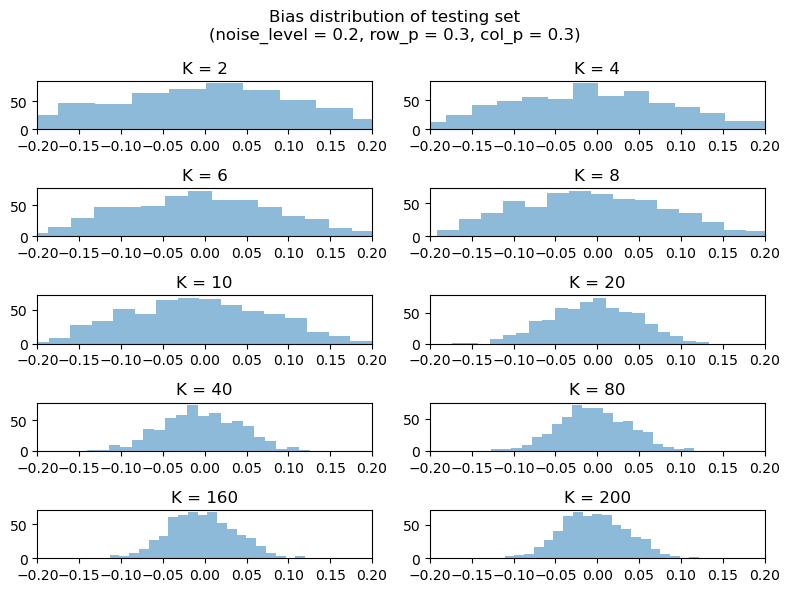

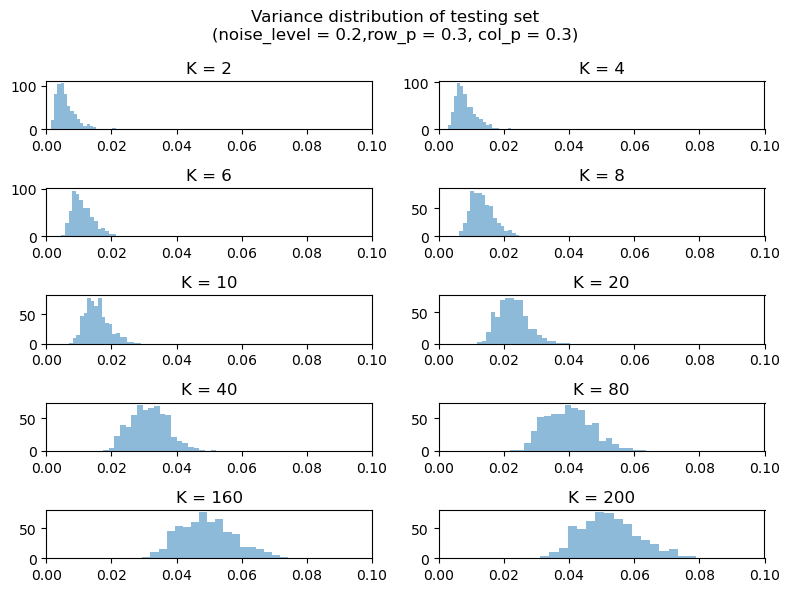

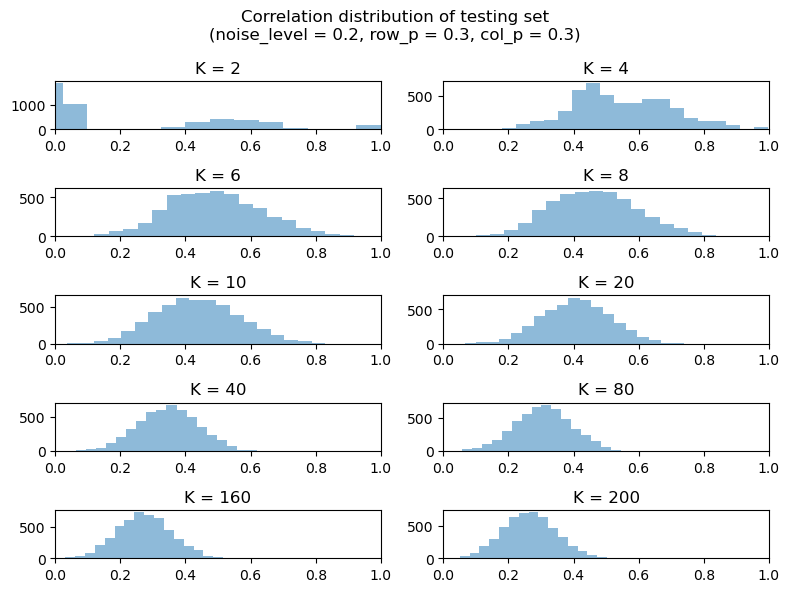

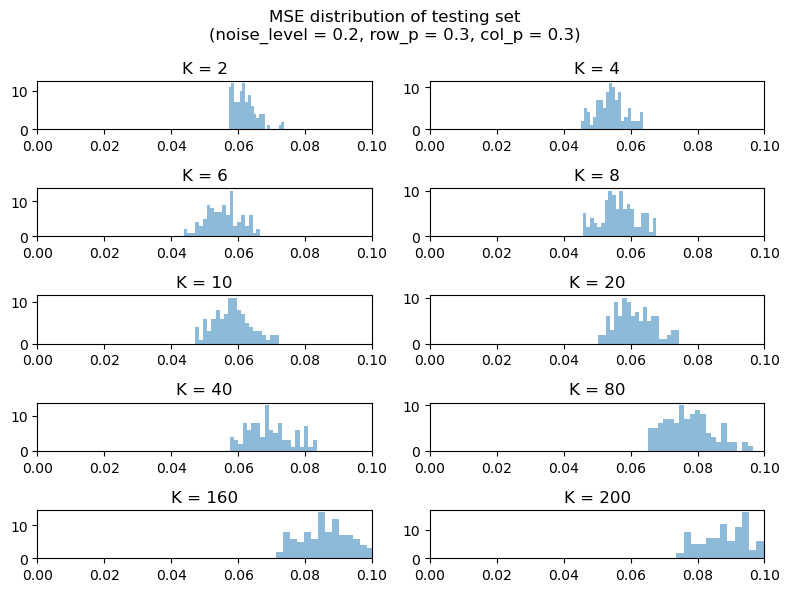

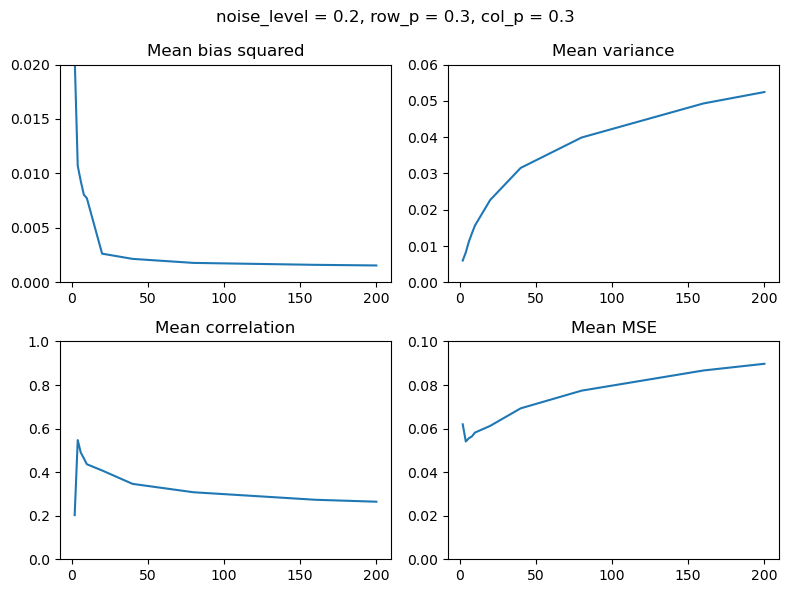

In [83]:
K_lst = [2, 4, 6, 8, 10, 20, 40, 80, 160, 200]
row_p = 0.3
col_p = 0.3
noise_level = 0.2
plot_hists(noise_level, K_lst, row_p, col_p, test_num = 100)

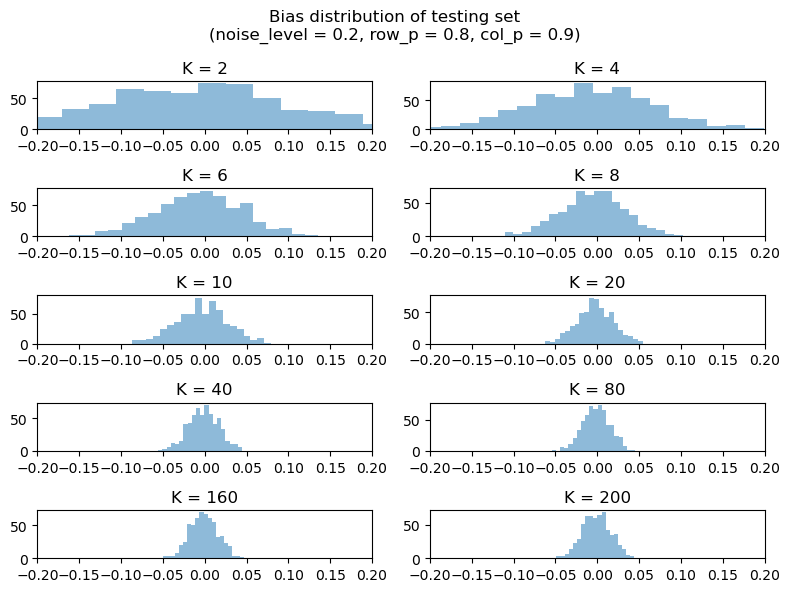

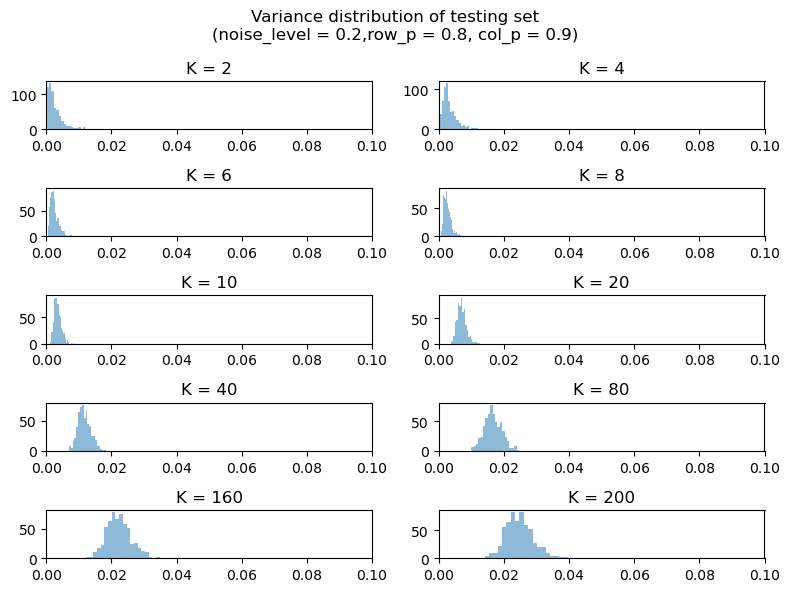

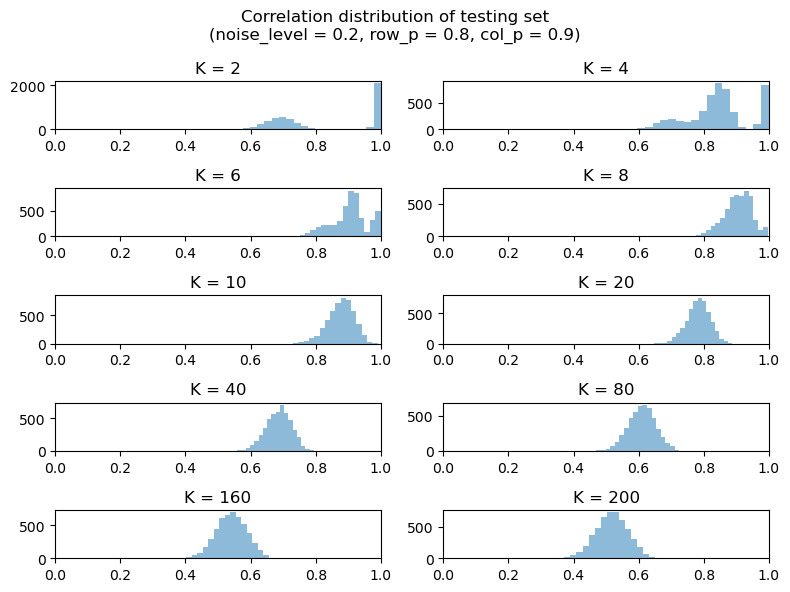

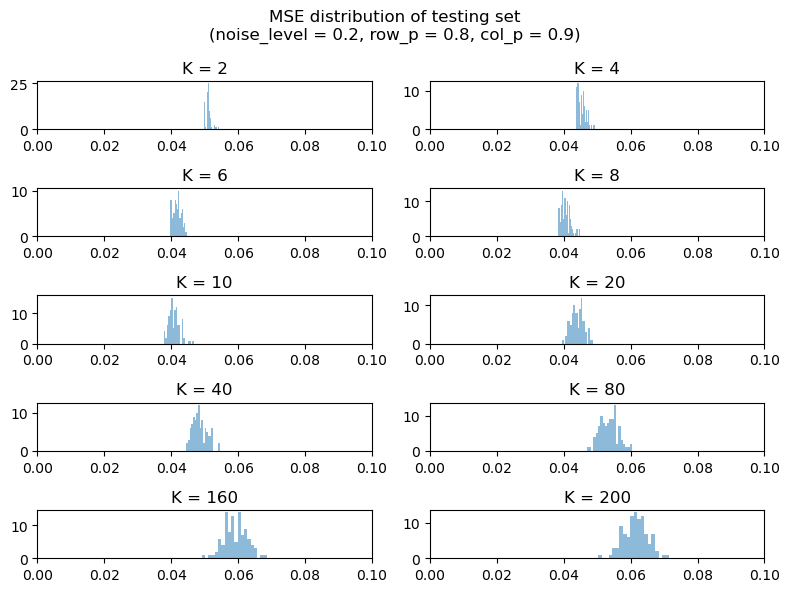

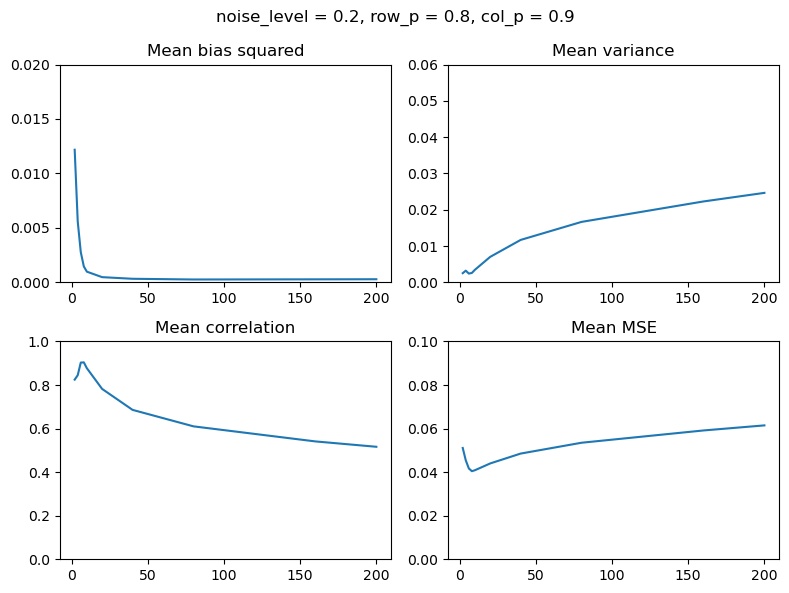

In [84]:
K_lst = [2, 4, 6, 8, 10, 20, 40, 80, 160, 200]
row_p = 0.8
col_p = 0.9
noise_level = 0.2
plot_hists(noise_level, K_lst, row_p, col_p, test_num = 100)